실습 파일: `10-neural-style-transfer.ipynb`

# Inside the conv layer

**Conv filter 시각화**

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

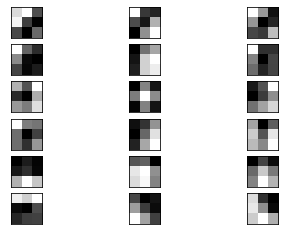

In [1]:
# summarize filters in each convolutional layer
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot

# load the model
model = VGG16()
model.summary()
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

# retrieve weights from the first hidden layer
filters, biases = model.layers[2].get_weights()
print(model.layers[2].name)

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

175582/175582 [==============================] - 0s 0us/step


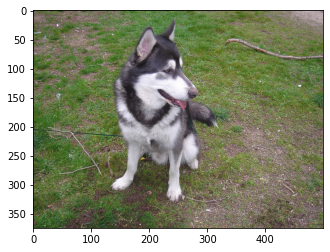

In [2]:
from matplotlib import image as mp_image
import matplotlib.pyplot as plt
from tensorflow import keras

url = 'https://raw.githubusercontent.com/kotech1/computervision/master/img/2011_002300-dog.jpg'

sample_image_path = keras.utils.get_file(
    "2011_002300-dog.jpg", url
)
image = mp_image.imread(sample_image_path)
plt.imshow(image)
plt.show()

**Activation value 시각화**

1/1 [==============================] - 8s 8s/step


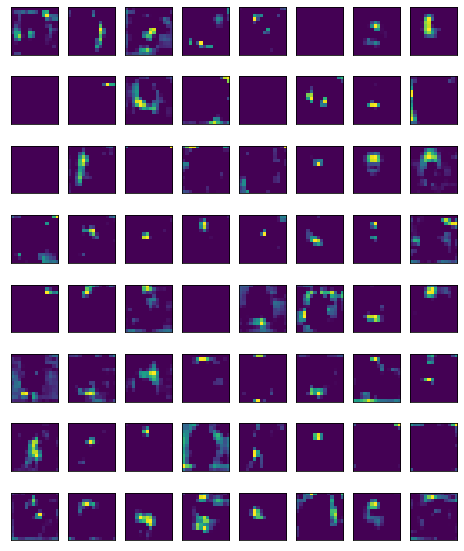

In [3]:
# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# load the model
model = VGG16()

layer = 16  # 1 to 17
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[layer].output)
# load the image with the required shape
#img = load_img('bird.jpg', target_size=(224, 224))
img = load_img(sample_image_path, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
offset = 0 # 0, 64, 128 ... 
pyplot.figure(figsize=(8,10))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        #pyplot.imshow(feature_maps[0, :, :, ix-1+offset], cmap='gray')
        img = feature_maps[0, :, :, ix-1+offset]
        import numpy as np
        img = np.clip(img, -1000, 1000)
        #pyplot.imshow(feature_maps[0, :, :, ix-1+offset])
        pyplot.imshow(img)
        ix += 1
# show the figure
pyplot.show()

# Neural Style Transfer

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

**손실함수 scale factors**

In [5]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

total_variation_weight = 5e-7
style_weight = 1e-5
content_weight = 2.5e-8

#
#total_variation_weight = 1e-8
#style_weight = 5e-5 #generated6
#content_weight = 1e-10

C: base_image  
S: style_reference_image  
G: combined_image  

In [6]:
base_image_path = keras.utils.get_file(
    "london-bridge.jpg", "https://pixy.org/src/0/thumbs350/123.jpg"
)
style_reference_image_path = keras.utils.get_file(
    "franz-marc.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg/691px-Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg"
)
result_prefix = 'london_generated'

117408/117408 [==============================] - 0s 0us/step


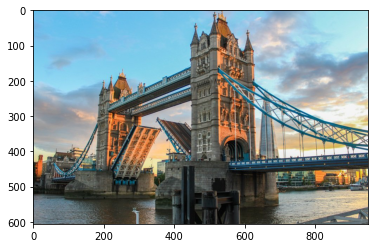

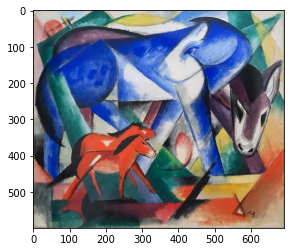

In [7]:
from matplotlib import image as mp_image
import matplotlib.pyplot as plt
img = mp_image.imread(base_image_path)
plt.imshow(img)
plt.show()

img = mp_image.imread(style_reference_image_path)
plt.imshow(img)
plt.show()

세로 방향을 400px로, aspect ratio를 유지하며 출력 이미지 크기 정의

In [8]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

VGG19의 image level normalization, de-normalization

In [9]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

**Gram matrix**

In [10]:
# 이미지 텐서의 gram matrix (특징별 outer product)

def gram_matrix(x):
    # 채널을 맨 앞으로, w,h를 뒤로 보냄
    x = tf.transpose(x, (2, 0, 1)) 
    # (c, h, w) ==> (c, w*h)
    features = tf.reshape(x, (tf.shape(x)[0], -1)) 
    # (c, w*h) x (w*h,c) = (c,c) 
    gram = tf.matmul(features, tf.transpose(features))  
    return gram

**Style Loss**

In [11]:
# style loss는 reference image와 generated image간의 
# 스타일 차이를 유지할 수 있도록 하는 역할을 한다.
# gram matrix의 차이의 squared error로 정의

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    # 논문의 정확한 implementation은 다음과 같아야 함
    # channels = style.shape[2]
    # size = style.shape[0] * style.shape[1] 
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Content Loss**

In [12]:
# 콘텐츠 손실 함수
# 생성된 이미지에서 base 이미지의 "content"를
# 유지하기 위함

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

**Total variation loss**

In [13]:
# 3번째 손실함수: total variation loss
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**VGG19**

In [14]:
# VGG19 model 로딩 (pre-trained ImageNet weights)
model = vgg19.VGG19(weights="imagenet", include_top=False)
model.summary()

# 모델에서 레이어 이름과 레이어 출력 형식을 가져옴
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# VGG 모델의 전체 activation value를 출력하는 함수 정의
# (dict 형식)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [15]:
# style loss에 사용할 레이어
#style_layer_names = [
#    "block1_conv1",
#    "block2_conv1",
#    "block3_conv1",
#    "block4_conv1",
#    "block5_conv1",
#]

style_layer_names = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv2",
    "block4_conv2",
    "block5_conv2",
]

# content loss에 사용할 레이어
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # loss 초기화
    loss = tf.zeros(shape=())

    # content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    c_loss = content_weight * content_loss(
        base_image_features, combination_features
    )
    s_loss = tf.zeros(shape=())
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        s_loss += (style_weight / len(style_layer_names)) * sl
    
    # total variation loss
    t_loss = total_variation_weight * total_variation_loss(combination_image)
    loss = c_loss+s_loss+t_loss 
    return loss, c_loss, s_loss, t_loss

In [16]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, t_loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, c_loss, s_loss, t_loss


**다음의 학습 코드를 수행하는 데에는 약3시간 정도 소요됩니다.**

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads, c_loss, s_loss, t_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0 or i == 1:
        print("Iteration %d: loss=%.2f, content_loss=%.2f, style_loss=%.2f, total_variation_loss=%.2f" %
               (i, loss, c_loss, s_loss, t_loss))
    if i % 100 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=169365.22, content_loss=0.00, style_loss=166242.94, total_variation_loss=3122.28
Iteration 10: loss=69605.17, content_loss=32.84, style_loss=67201.55, total_variation_loss=2370.78


In [ ]:
img = mp_image.imread(result_prefix + '_at_iteration_'+'%d.png'%1300)
plt.imshow(img)
plt.show()

In [ ]:
img = mp_image.imread(result_prefix + '_at_iteration_'+'%d.png'%100)
plt.imshow(img)
plt.show()